# Pricing Elasticity

## Load data

Data is taken from [Kaggle](https://www.kaggle.com/datasets/suddharshan/retail-price-optimization?datasetId=1865343).

In [1]:
import pandas as pd
import numpy as np

def get_text(r):
    product_category_name = r['product_category_name']
    

df = pd.read_csv('./data/retail_price.csv') \
    .assign(
        month_year=lambda d: pd.to_datetime(d['month_year']),
        year=lambda d: d['month_year'].dt.year,
        month=lambda d: d['month_year'].dt.month,
        weekend=lambda d: d['weekday'].apply(lambda x: 1 if x >= 5 else 0),
        text=lambda d: d['product_category_name'].apply(lambda s: ' '.join(s.split('_')))
    )
df.shape

(676, 31)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   product_id                  676 non-null    object        
 1   product_category_name       676 non-null    object        
 2   month_year                  676 non-null    datetime64[ns]
 3   qty                         676 non-null    int64         
 4   total_price                 676 non-null    float64       
 5   freight_price               676 non-null    float64       
 6   unit_price                  676 non-null    float64       
 7   product_name_lenght         676 non-null    int64         
 8   product_description_lenght  676 non-null    int64         
 9   product_photos_qty          676 non-null    int64         
 10  product_weight_g            676 non-null    int64         
 11  product_score               676 non-null    float64       

## Visualize pricing elasticity of demand

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='qty', ylabel='unit_price'>

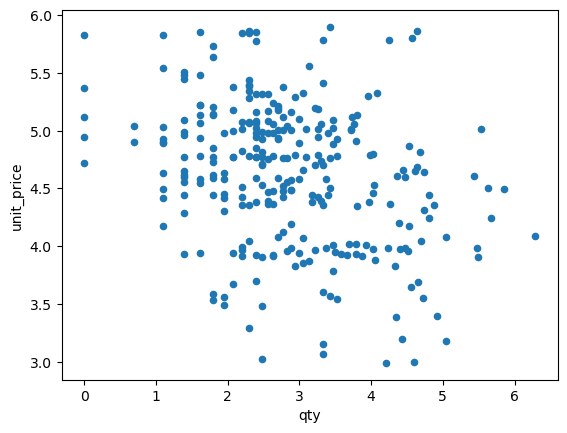

In [3]:
df[['unit_price', 'qty']] \
    .groupby(['unit_price']) \
    .sum() \
    .reset_index() \
    .assign(
        unit_price=lambda d: np.log(d['unit_price']),
        qty=lambda d: np.log(d['qty'])
    ) \
    .plot(kind='scatter', x='qty', y='unit_price')

## Split into training/testing

In [4]:
df['month_year'].value_counts().sort_index()

2017-01-01     2
2017-01-02     9
2017-01-03    13
2017-01-04    15
2017-01-05    20
2017-01-06    25
2017-01-07    33
2017-01-08    37
2017-01-09    36
2017-01-10    43
2017-01-11    44
2017-01-12    44
2018-01-01    48
2018-01-02    49
2018-01-03    50
2018-01-04    48
2018-01-05    40
2018-01-06    42
2018-01-07    40
2018-01-08    38
Name: month_year, dtype: int64

In [5]:
df_tr = df[df['month_year'] <= '2017-12-31']
df_te = df[df['month_year'] >= '2018-01-01']

df_tr.shape, df_te.shape

((321, 31), (355, 31))

## Simple log-log model

$\log{Q} \sim \log{P}$

In [6]:
Xy_tr = df_tr.groupby(['unit_price']) \
    .agg(qty_sum=pd.NamedAgg(column='qty', aggfunc='sum')) \
    .assign(qty_sum=lambda d: np.log(d['qty_sum'])) \
    .reset_index() \
    .assign(unit_price=lambda d: np.log(d['unit_price']))

Xy_te = df_te.groupby(['unit_price']) \
    .agg(qty_sum=pd.NamedAgg(column='qty', aggfunc='sum')) \
    .assign(qty_sum=lambda d: np.log(d['qty_sum'])) \
    .reset_index() \
    .assign(unit_price=lambda d: np.log(d['unit_price']))

X_tr = Xy_tr[['unit_price']]
X_te = Xy_te[['unit_price']]

y_tr = Xy_tr['qty_sum']
y_te = Xy_te['qty_sum']

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((128, 1), (181, 1), (128,), (181,))

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

def get_performance(y_tr, z_tr, y_te, z_te):
    y_tr = np.exp(y_tr)
    z_tr = np.exp(z_tr)
    
    y_te = np.exp(y_te)
    z_te = np.exp(z_te)
    
    mae_tr = mean_absolute_error(y_tr, z_tr)
    mae_te = mean_absolute_error(y_te, z_te)
    
    s = pd.Series([
        mae_tr,
        mae_te,
        mae_tr / (y_tr.max() - y_tr.min()), 
        mae_te / (y_te.max() - y_te.min()),
        mae_tr / y_tr.std(), 
        mae_te / y_te.std(),
        mae_tr / y_tr.mean(), 
        mae_te / y_te.mean()
    ], index=['mae_tr', 'mae_te', 'range_mae_tr', 'range_mae_te', 'std_mae_tr', 'std_mae_te', 'mean_mae_tr', 'mean_mae_te'])
    
    return s

models = [
    LinearRegression(),
    RandomForestRegressor(n_jobs=-1, random_state=37, n_estimators=25),
    LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=10, n_estimators=50, max_depth=2)
]

for m in models:
    m.fit(X_tr, y_tr)
    
pd.DataFrame([get_performance(y_tr, m.predict(X_tr), y_te, m.predict(X_te)) 
              for m in models], index=['OLS', 'RF', 'GBT'])

,mae_tr,mae_te,range_mae_tr,range_mae_te,std_mae_tr,std_mae_te,mean_mae_tr,mean_mae_te
OLS,24.973284,21.790472,0.046679,0.076998,0.392888,0.509473,0.735184,0.723551
RF,12.091052,31.956025,0.022600,0.112919,0.190221,0.747149,0.355946,1.061097
GBT,24.513070,22.900274,0.045819,0.080920,0.385648,0.535421,0.721636,0.760402


In [14]:
simple_loglog_lr, simple_loglog_rf, simple_loglog_gb = models

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


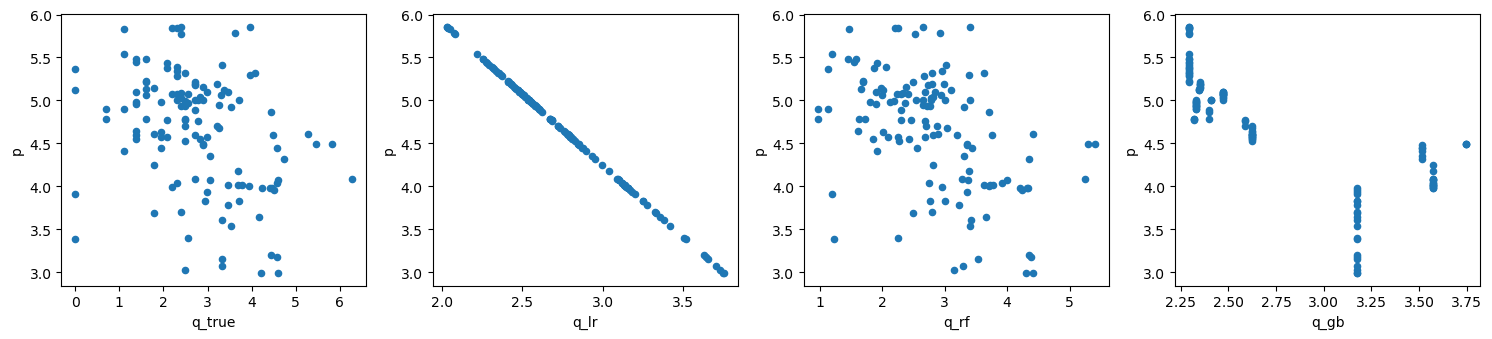

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1 = pd.DataFrame({
    'p': X_tr['unit_price'].values,
    'q_true': y_tr.values,
    'q_lr': simple_loglog_lr.predict(X_tr),
    'q_rf': simple_loglog_rf.predict(X_tr),
    'q_gb': simple_loglog_gb.predict(X_tr)
})

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


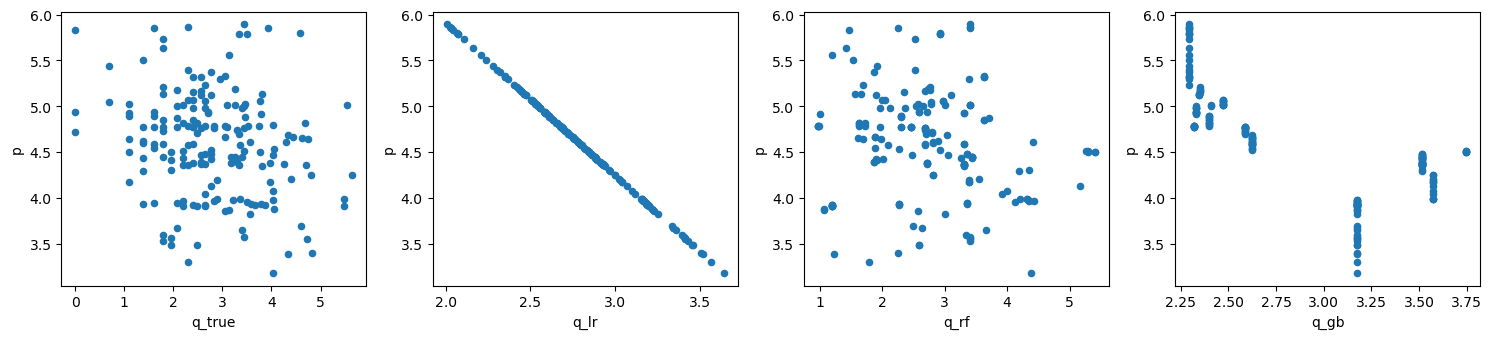

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df2 = pd.DataFrame({
    'p': X_te['unit_price'].values,
    'q_true': y_te.values,
    'q_lr': simple_loglog_lr.predict(X_te),
    'q_rf': simple_loglog_rf.predict(X_te),
    'q_gb': simple_loglog_gb.predict(X_te)
})

_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

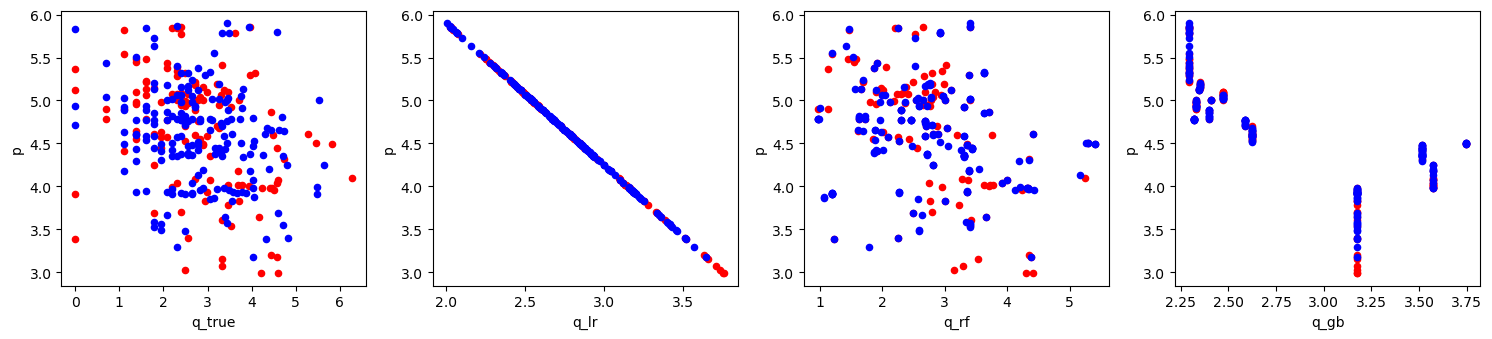

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='r')
_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='b')

_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='r')
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='b')

_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='r')
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='b')

_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='r')
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='b')

fig.tight_layout()

## Log-log model with features

$\log{Q} \sim \log{P} + X_1 + X_2 + \ldots + X_n$

In [18]:
def get_Xy(df):
    a = df.groupby(['product_category_name', 'unit_price']) \
        .agg(qty_sum=pd.NamedAgg(column='qty', aggfunc='sum')) \
        .assign(qty_sum=lambda d: np.log(d['qty_sum'])) \
        .rename(columns={'qty_sum': 'quantity'})
    
    b = df.groupby(['product_category_name', 'unit_price']) \
        .agg(
            freight_price=pd.NamedAgg(column='freight_price', aggfunc='mean'),
            product_score=pd.NamedAgg(column='product_score', aggfunc='mean'),
            weekday=pd.NamedAgg(column='weekday', aggfunc='mean'),
            holiday=pd.NamedAgg(column='holiday', aggfunc='mean'),
            customers=pd.NamedAgg(column='customers', aggfunc='mean'),
            volume=pd.NamedAgg(column='volume', aggfunc='mean'),
            s=pd.NamedAgg(column='s', aggfunc='mean'),
            comp_1=pd.NamedAgg(column='comp_1', aggfunc='mean'),
            ps1=pd.NamedAgg(column='ps1', aggfunc='mean'),
            fp1=pd.NamedAgg(column='fp1', aggfunc='mean'),
            comp_2=pd.NamedAgg(column='comp_2', aggfunc='mean'),
            ps2=pd.NamedAgg(column='ps2', aggfunc='mean'),
            fp2=pd.NamedAgg(column='fp2', aggfunc='mean'),
            comp_3=pd.NamedAgg(column='comp_3', aggfunc='mean'),
            ps3=pd.NamedAgg(column='ps3', aggfunc='mean'),
            fp3=pd.NamedAgg(column='fp3', aggfunc='mean'),
            lag_price=pd.NamedAgg(column='lag_price', aggfunc='mean')
        )
    
    Xy = a \
        .join(b, how='left') \
        .reset_index() \
        .assign(unit_price=lambda d: np.log(d['unit_price']))
    
    c = pd.get_dummies(Xy[['product_category_name']]).iloc[:,1:]
    
    Xy = Xy.join(c, how='left').drop(columns=['product_category_name'])
    
    X = Xy[Xy.columns.drop(['quantity'])]
    y = Xy['quantity']
    
    return X, y

X_tr, y_tr = get_Xy(df_tr)
X_te, y_te = get_Xy(df_te)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((133, 26), (188, 26), (133,), (188,))

In [19]:
models = [
    LinearRegression(),
    RandomForestRegressor(n_jobs=-1, random_state=37, n_estimators=25),
    LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=10, n_estimators=50, max_depth=2)
]

for m in models:
    m.fit(X_tr, y_tr)
    
pd.DataFrame([get_performance(y_tr, m.predict(X_tr), y_te, m.predict(X_te)) 
              for m in models], index=['OLS', 'RF', 'GBT'])

,mae_tr,mae_te,range_mae_tr,range_mae_te,std_mae_tr,std_mae_te,mean_mae_tr,mean_mae_te
OLS,21.592945,28.363898,0.040361,0.100226,0.357261,0.677601,0.660502,0.978245
RF,10.259959,20.777510,0.019177,0.073419,0.169754,0.496366,0.313840,0.716597
GBT,15.886894,19.211437,0.029695,0.067885,0.262853,0.458953,0.485961,0.662585


In [20]:
features_loglog_lr, features_loglog_rf, features_loglog_gb = models

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


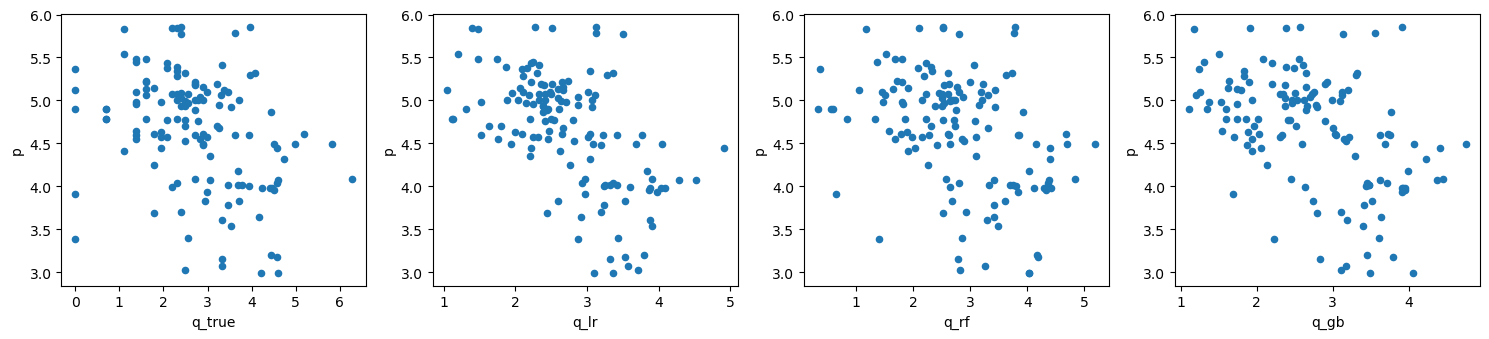

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1 = pd.DataFrame({
    'p': X_tr['unit_price'].values,
    'q_true': y_tr.values,
    'q_lr': features_loglog_lr.predict(X_tr),
    'q_rf': features_loglog_rf.predict(X_tr),
    'q_gb': features_loglog_gb.predict(X_tr)
})

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


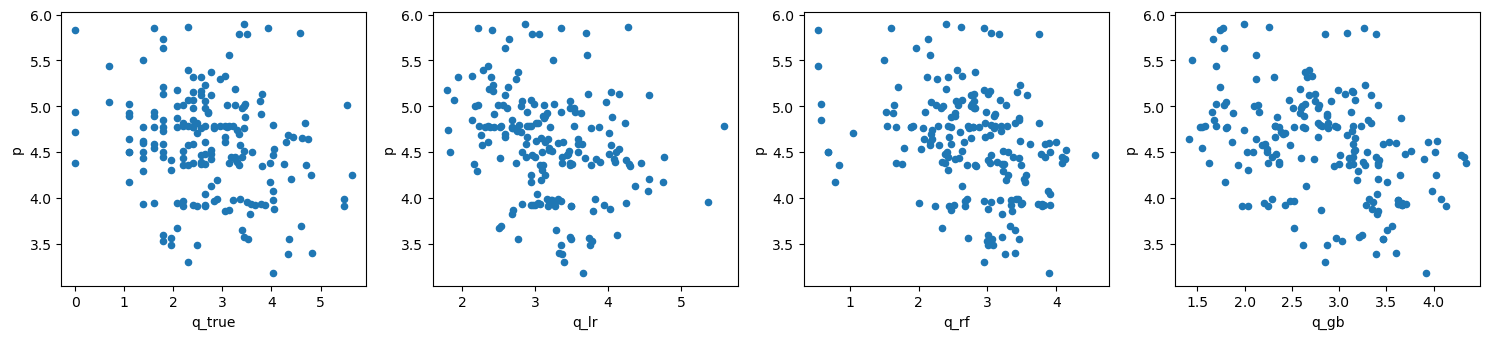

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df2 = pd.DataFrame({
    'p': X_te['unit_price'].values,
    'q_true': y_te.values,
    'q_lr': features_loglog_lr.predict(X_te),
    'q_rf': features_loglog_rf.predict(X_te),
    'q_gb': features_loglog_gb.predict(X_te)
})

_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

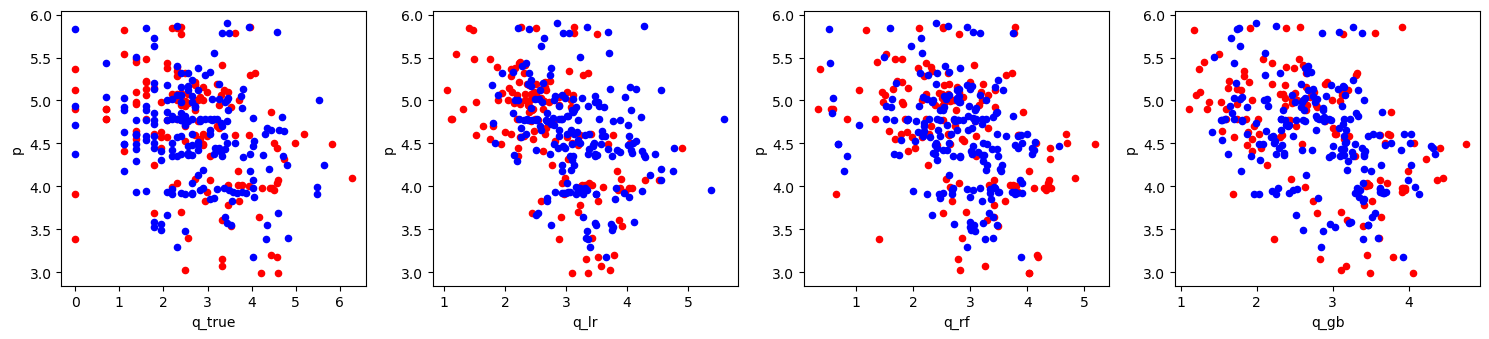

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='r')
_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='b')

_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='r')
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='b')

_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='r')
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='b')

_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='r')
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='b')

fig.tight_layout()

## MERF model

$y_i = f(X_i) + Z_i u_i + e_i$

In [24]:
p2i = {c: i for i, c in enumerate(list(df['product_category_name'].unique()))}
i2p = {v: k for k, v in p2i.items()}

p2i

{'bed_bath_table': 0,
 'garden_tools': 1,
 'consoles_games': 2,
 'health_beauty': 3,
 'cool_stuff': 4,
 'perfumery': 5,
 'computers_accessories': 6,
 'watches_gifts': 7,
 'furniture_decor': 8}

In [25]:
def get_Xy(df):
    a = df.groupby(['product_id', 'product_category_name', 'unit_price']) \
        .agg(
            qty_sum=pd.NamedAgg(column='qty', aggfunc='sum'),
            freight_price=pd.NamedAgg(column='freight_price', aggfunc='mean'),
            product_score=pd.NamedAgg(column='product_score', aggfunc='mean'),
            comp_1=pd.NamedAgg(column='comp_1', aggfunc='mean'),
            ps1=pd.NamedAgg(column='ps1', aggfunc='mean'),
            fp1=pd.NamedAgg(column='fp1', aggfunc='mean'),
            comp_2=pd.NamedAgg(column='comp_2', aggfunc='mean'),
            ps2=pd.NamedAgg(column='ps2', aggfunc='mean'),
            fp2=pd.NamedAgg(column='fp2', aggfunc='mean'),
            comp_3=pd.NamedAgg(column='comp_3', aggfunc='mean'),
            ps3=pd.NamedAgg(column='ps3', aggfunc='mean'),
            fp3=pd.NamedAgg(column='fp3', aggfunc='mean'),
            lag_price=pd.NamedAgg(column='lag_price', aggfunc='mean')
        ) \
        .assign(
            qty_sum=lambda d: np.log(d['qty_sum'])
        ) \
        .rename(columns={'qty_sum': 'quantity'}) \
        .reset_index() \
        .drop(columns=['product_id']) \
        .set_index(['product_category_name', 'unit_price'])
    
    b = df.groupby(['product_category_name', 'unit_price']) \
        .agg(
            weekday=pd.NamedAgg(column='weekday', aggfunc='mean'),
            holiday=pd.NamedAgg(column='holiday', aggfunc='mean'),
            customers=pd.NamedAgg(column='customers', aggfunc='mean'),
            volume=pd.NamedAgg(column='volume', aggfunc='mean'),
            s=pd.NamedAgg(column='s', aggfunc='mean')
        )
    
    Xy = a \
        .join(b, how='inner') \
        .reset_index() \
        .assign(unit_price=lambda d: np.log(d['unit_price']))
    
    Xy = Xy.assign(product_category_name=lambda d: d['product_category_name'].map(p2i))
    
    X = Xy[Xy.columns.drop(['quantity', 'product_category_name', 'weekday', 'holiday', 'customers', 'volume', 's'])]
    Z = Xy[['weekday', 'holiday', 'customers', 's', 'lag_price']]
    C = Xy['product_category_name']
    y = Xy['quantity']
    
    return X, Z, C, y

X_tr, Z_tr, C_tr, y_tr = get_Xy(df_tr)
X_te, Z_te, C_te, y_te = get_Xy(df_te)

In [26]:
X_tr.shape, Z_tr.shape, C_tr.shape, y_tr.shape

((148, 13), (148, 5), (148,), (148,))

In [27]:
X_te.shape, Z_te.shape, C_te.shape, y_te.shape

((208, 13), (208, 5), (208,), (208,))

In [28]:
from merf import MERF

merf = MERF(
    fixed_effects_model=LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=10, n_estimators=25, max_depth=2),
    max_iterations=30
)
merf.fit(X_tr, Z_tr, C_tr, y_tr)
get_performance(y_tr, merf.predict(X_tr, Z_tr, C_tr), y_te, merf.predict(X_te, Z_te, C_te))

INFO     [merf.py:307] Training GLL is -101.1968163353814 at iteration 1.
INFO     [merf.py:307] Training GLL is -171.1640578010463 at iteration 2.
INFO     [merf.py:307] Training GLL is -212.75117154771698 at iteration 3.
INFO     [merf.py:307] Training GLL is -237.39499667414066 at iteration 4.
INFO     [merf.py:307] Training GLL is -251.62779481759006 at iteration 5.
INFO     [merf.py:307] Training GLL is -261.7722548740787 at iteration 6.
INFO     [merf.py:307] Training GLL is -270.9140854853618 at iteration 7.
INFO     [merf.py:307] Training GLL is -277.83585751275916 at iteration 8.
INFO     [merf.py:307] Training GLL is -284.21616758351246 at iteration 9.
INFO     [merf.py:307] Training GLL is -291.04387362987586 at iteration 10.
INFO     [merf.py:307] Training GLL is -296.8627723342258 at iteration 11.
INFO     [merf.py:307] Training GLL is -301.2918249231089 at iteration 12.
INFO     [merf.py:307] Training GLL is -309.26393558352703 at iteration 13.
INFO     [merf.py:307] Trai

mae_tr          15.590045
mae_te          18.394509
range_mae_tr     0.045853
range_mae_te     0.064998
std_mae_tr       0.388801
std_mae_te       0.529736
mean_mae_tr      0.530664
mean_mae_te      0.701900
dtype: float64

In [29]:
pd.Series(merf.fe_model.feature_importances_, X_tr.columns) \
    .sort_values(ascending=False)

unit_price       25
freight_price    11
fp1               9
fp2               7
comp_3            7
ps3               4
ps2               3
fp3               2
lag_price         2
product_score     0
comp_1            0
ps1               0
comp_2            0
dtype: int32

In [30]:
merf.trained_b.sort_index() \
    .rename(columns={0: 'weekday', 1: 'holiday', 2: 'customers', 3: 'volume', 4: 's', 5: 'lag_price'}) \
    .T \
    .rename(columns=i2p).T

,weekday,holiday,customers,volume,s
bed_bath_table,-0.007945,-0.186044,0.000864,0.035106,-0.002121
garden_tools,-0.030065,-0.062398,0.001513,0.052798,-0.004259
consoles_games,-0.004937,-0.007303,0.000203,0.009453,-0.000838
health_beauty,0.016584,-0.038887,-0.000543,-0.018656,0.001668
cool_stuff,0.003853,0.133319,0.000107,-0.026230,0.001764
perfumery,-0.003835,-0.027635,0.000262,0.009871,-0.000816
computers_accessories,-0.028299,0.319809,0.001429,-0.003708,-0.001072
watches_gifts,-0.030244,0.035122,0.002325,0.034548,-0.002885
furniture_decor,0.007239,0.042501,-0.000677,-0.013164,0.000763


/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


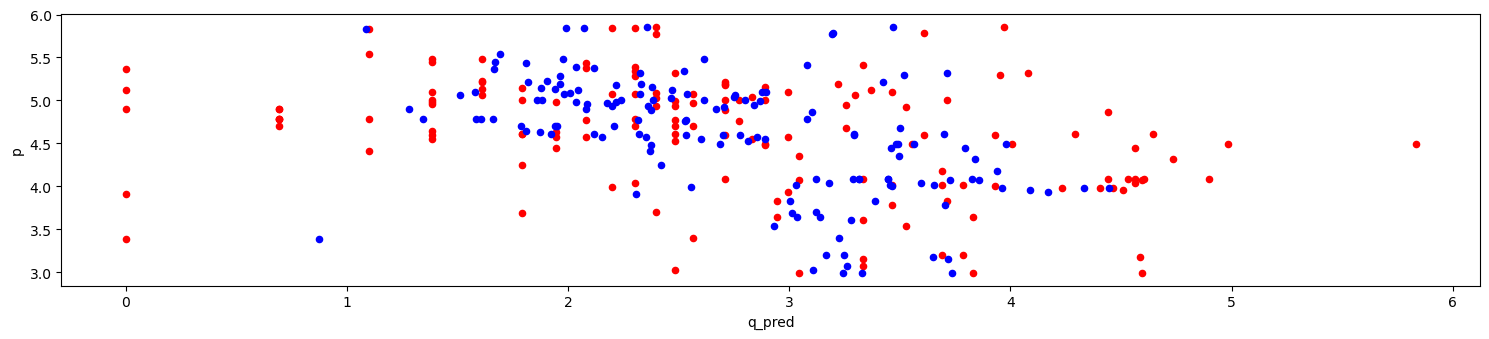

In [31]:
fig, ax = plt.subplots(figsize=(15, 3.5))

_df1 = pd.DataFrame({
    'p': X_tr['unit_price'].values,
    'q_true': y_tr.values,
    'q_pred': merf.predict(X_tr, Z_tr, C_tr)
})

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax, color='r')
_df1.plot(kind='scatter', x='q_pred', y='p', ax=ax, color='b')

fig.tight_layout()

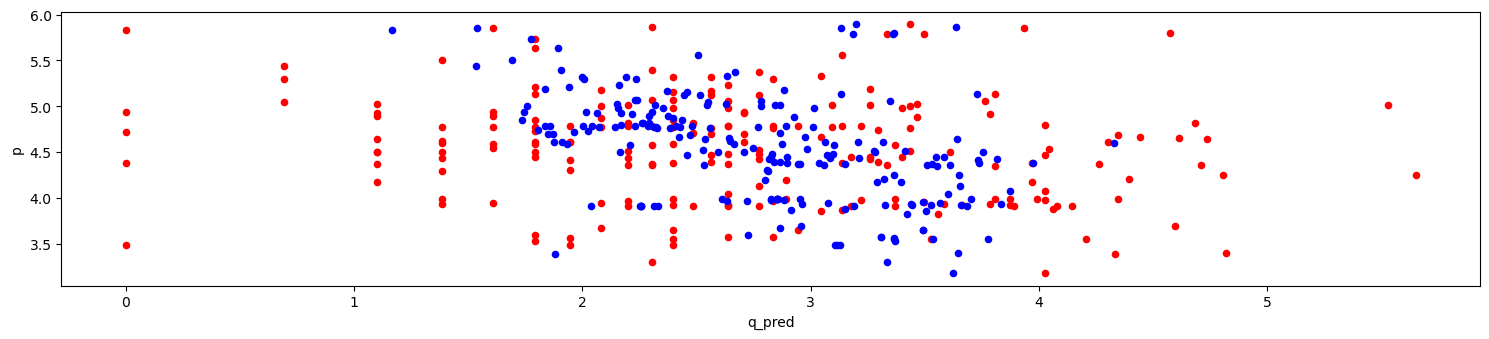

In [32]:
fig, ax = plt.subplots(figsize=(15, 3.5))

_df2 = pd.DataFrame({
    'p': X_te['unit_price'].values,
    'q_true': y_te.values,
    'q_pred': merf.predict(X_te, Z_te, C_te)
})

_df2.plot(kind='scatter', x='q_true', y='p', ax=ax, color='r')
_df2.plot(kind='scatter', x='q_pred', y='p', ax=ax, color='b')

fig.tight_layout()